# Setup & Initialization

Must be run to ensure functionality

### Libraries

In [ ]:
!pip install biosignalsnotebooks
#Notes on BSNB
#Functions used:
#To inspect signal: bsnb.plot
#To load header: bsnb.load
#To generate time axis: bsnb

!apt-get install libmagic-dev
!pip install python-magic
import magic
import biosignalsnotebooks as bsnb
import sys
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import h5py

from scipy import signal

import math

from google.colab import drive 
drive.mount('/content/gdrive')



Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmagic-dev is already the newest version (1:5.32-2ubuntu0.4).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Function Definitions

In [ ]:
#Function demonstrating data use without bsnb or hdf5
#col[-1] gives the last channel
#Use for sanity checking
def pltEMG_mV(path, fname, channels):
  x=np.loadtxt(path + fname)
  i = 1
  while(i <= channels):
    plt.figure()
    plt.plot((x[0:23000,-i]/(2**10)-0.5)*3.3/1009*1000,'k')
    plt.ylim([-1.63,1.63])
    plt.ylabel('mV')
    plt.xlabel('t (ms)')
    plt.title(fname + ':EMG_Channel_' + str(channels - i + 1))


#Unit Conversion Formula Shorthand
#Check Transfer Function Unit Conversion Module (https://colab.research.google.com/drive/1ckLhg4Z2AqiEbnqyNc90z4axWWfgBVlA?authuser=1#scrollTo=lq-ILcA-Pcu5&line=2&uniqifier=1)
#For clear calculations with defined variables
#Input: Raw 10-bit ADC values
#Output: [-1.64, 1.64] mV
def transfer_function(signal):
  return (((np.array(signal) / 2**10) - 0.5) * 3300) / 1009


#Redundant, use bsnb function instead to generate time axis
#Does the same thing, with nice convenient truncated time units
#bsnb.generate_time(signal, sr) 
def time_axis_array(signal, sampling_rate):
  samplecount = len(signal)
  duration = samplecount/sampling_rate
  axis =  (np.linspace(0, duration, samplecount), 3)
  return axis

# User Manual

## Selecting Your Own Data Sample

Modifying other sections may break stuff

fname is the filename, WITHOUT the extension and
fdir is the directory the file is located in

If left unspecified, the default data sample is Christian saying Pineapple 

In [ ]:
fdir = '/content/gdrive/MyDrive/__SPRING 2022/SNOD/SilentSpeechDAS/_SampleData/'
fname = 'yn_test_christian_3_9_22_I'
fname = '1chforearmtest1'

## Hierarchical Data Formatting and Header Parsing (.h5)

### HDF5 Formatting and Data Attributes/Metadata (Direct )

In [ ]:
if fname:
  print("Using user sample...")
else:
  print("Using default sample...")
  fdir = '/content/gdrive/MyDrive/__SPRING 2022/SNOD/SilentSpeechDAS/_SampleData/'
  fname = 'pineappleTest'
  
fpath_h5 = fdir + fname + '.h5'

h5_object = h5py.File(fpath_h5)
print("HDF5 File: " + str(h5_object))

mac_addresses = list(h5_object.keys())
deviceMAC = mac_addresses[0]
print ("First hierarchy level (MAC address): " + str(deviceMAC))

h5_group = h5_object.get(deviceMAC)
print ("Second hierarchy level (Groups): " + str(list(h5_group)))
print ("\tuse 'raw' subgroup to access signals")

print ("\nMetadata Attributes of Group: \n\t" + str("\n\t".join(list(h5_group.attrs.keys()))))

sampling_rate = h5_group.attrs.get("sampling rate")
print ("\nSampling Rate: " + str(sampling_rate))

h5_sub_group = h5_group.get("raw")
print("\nThird hierarchy level (raw EMG data): " + str(list(h5_sub_group)))

h5_data = h5_sub_group.get("channel_1")
print("Access required channel: " + str(h5_data))

data_list = [item for sublist in h5_data for item in sublist]
print("Raw ADC Data: " + str(data_list))


Using user sample...
HDF5 File: <HDF5 file "1chforearmtest1.h5" (mode r)>
First hierarchy level (MAC address): 20:19:07:00:80:D4
Second hierarchy level (Groups): ['digital', 'events', 'plugin', 'raw', 'support']
	use 'raw' subgroup to access signals

Metadata Attributes of Group: 
	channels
	comments
	date
	device
	device connection
	device name
	digital IO
	duration
	firmware version
	keywords
	macaddress
	mode
	nsamples
	resolution
	sampling rate
	sync interval
	time

Sampling Rate: 1000

Third hierarchy level (raw EMG data): ['channel_1', 'nSeq']
Access required channel: <HDF5 dataset "channel_1": shape (4650, 1), type "<u4">
Raw ADC Data: [503, 499, 495, 491, 493, 501, 507, 513, 520, 522, 526, 527, 526, 526, 519, 517, 508, 503, 498, 495, 492, 496, 500, 504, 514, 519, 519, 526, 533, 531, 527, 518, 516, 507, 499, 495, 491, 492, 497, 502, 511, 517, 524, 526, 529, 528, 528, 522, 519, 511, 504, 498, 496, 488, 490, 499, 506, 512, 521, 525, 526, 528, 531, 530, 525, 515, 507, 501, 497, 493

### Header Parsing with BSNB

In [ ]:
data, header = bsnb.load(fpath_h5, get_header=True)
#get information which is stored inside variables
ch = "CH1" # Channel
sr = header["sampling rate"] 
resolution = 10 # Resolution (number of available bits)
device = header["device"]
time = header["time"]
#RAW DATA
signal = data[ch] 

print(data)

# Signal
print("Data Sample: " + fname)
print("Device: " + str(device) + ": " + str(deviceMAC))
print("Channel: " + ch)
print("Resolution: " + str(resolution))
print("Sampling Rate: " + str(sr))
print("Timestamp: " + str(time))  

print("Raw ADC Value Array: " + str(signal))

{'CH1': array([503, 499, 495, ..., 512, 507, 508], dtype=uint32)}
Data Sample: 1chforearmtest1
Device: bitalino_rev: 20:19:07:00:80:D4
Channel: CH1
Resolution: 10
Sampling Rate: 1000
Timestamp: 9:58:32.147
Raw ADC Value Array: [503 499 495 ... 512 507 508]


## Signal Acquisition/Pre-Processing
from an array of 10 bit ADC values to the EMG signal

### Transfer Function Unit Conversion and Sample Plot



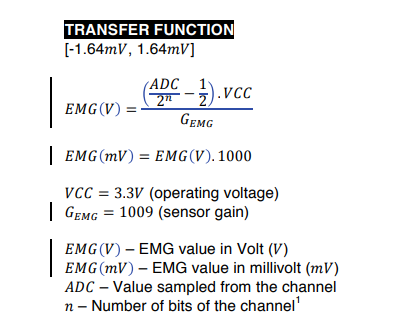

In [ ]:
# Transfer Function Conversion Formula
sr = header["sampling rate"] # = 1000 ie Sampling Rate 
resolution = 10 # = 10 ie Resolution
vcc = 3300 #mV
gain  = 1009
signal_mv = (((np.array(signal) / 2**resolution) - 0.5) * vcc) / gain
time = bsnb.generate_time(signal, sr) 

#The library has a simple function that does 

bsnb.plot([time, time], [signal, signal_mv], y_axis_label=["Raw Data", "Electric Tension (mV)"], grid_lines=1, grid_columns=2, grid_plot=True)

#np.set_printoptions(threshold=np.inf) Uncomment to visualize entire array
print("Raw ADC Value: " + str(signal))
print("mV Value: " + str(signal_mv))

Raw ADC Value: [503 499 495 ... 512 507 508]
mV Value: [-0.0287452  -0.04152084 -0.05429649 ...  0.         -0.01596956
 -0.01277564]


### Filtering/Pre-processing (SciPy)


In [27]:
from biosignalsnotebooks import signal_samples
from scipy.signal import filtfilt, butter, iirnotch

fpath_h5 = '/content/gdrive/MyDrive/__SPRING 2022/SNOD/SilentSpeechDAS/_SampleData/4channeltest.h5'

data, header = bsnb.load(fpath_h5, get_header=True)
print("Data Sample:" + str(fpath_h5))

ch = "CH1" # Channel
sr = header["sampling rate"] 
resolution = 10 # Resolution (number of available bits)

signal_raw = np.array(data[ch])
signal_raw = transfer_function(signal_raw)
time = bsnb.generate_time(signal_raw, sr)

signal_meancorrect= signal_raw - np.mean(signal_raw)

#60Hz Notch Filter for Power Line Noise
b, a = iirnotch(60, 30, 1000)
signal_notched = filtfilt(b, a, signal_meancorrect)

# [Band Pass to demonstrate most prominent frequency range]
high_cutoff = 50
low_cutoff = 150

# Fourth Order Butterworth 
b, a = butter(4, [(high_cutoff * 2)/sr, (low_cutoff * 2)/sr], btype='bandpass')
signal_filtered = filtfilt(b, a, signal_notched)

#Rectify signal
signal_rect = abs(signal_filtered)


#bsnb.plot([time], [signal_raw], legend_label=["Original Signal"], y_axis_label=["Raw Data", "Raw Data"], x_axis_label="Time (s)")
bsnb.plot([time, time], [signal_raw, signal_filtered], legend = ["Signal", "Filtered, Mean Corrected Signal", "Rectified Signal"], y_axis_label=["Electric Tension (mV)", "Electric Tension (mV)"], grid_lines=1, grid_columns=3, grid_plot=True)
bsnb.plot([time], [signal_rect], legend = ["Rectified Signal"], y_axis_label=["Electric Tension (mV)"], grid_lines=1, grid_columns=1, grid_plot=True)


Output hidden; open in https://colab.research.google.com to view.

# Codebook


### Example One: Demo

In [24]:
#Simple Example for converting OpenSignals HDF5 file to Motor Unit Potential in mV
import random

fSample = '/content/gdrive/MyDrive/__SPRING 2022/SNOD/SilentSpeechDAS/_SampleData/4channeltest.h5'
data, header = bsnb.load(fSample, get_header=True)

chList = ["CH1", "CH2", "CH3", "CH4"] # Channel
sr = header["sampling rate"] 
resolution = 10 # Resolution (number of available bits)
for ch in chList:
  signal = data[ch]
  time = bsnb.generate_time(signal, sr)
  signal_mv = transfer_function(signal)
  bsnb.plot([time], [signal_mv], y_axis_label=["Electric Tension (mV)" + str(ch)], grid_lines=1, grid_columns=1, grid_plot=True)

samples = len(signal_mv)
randomSlice = random.randint(0, samples - 200)
print("Samples Collected: " + str(samples))
print("Random slice: [" + str(randomSlice) + "," + str(randomSlice + 100) + ']')
print("\nSample Raw ADC Data: " + str(signal[randomSlice:randomSlice + 100]))
print("\nCorresponding mV units: " + str(signal_mv[randomSlice:randomSlice + 100]))
print("\nCorresponding time axis: " + str(time[randomSlice:randomSlice + 100]))


Output hidden; open in https://colab.research.google.com to view.

### Example Two: Filtering